# PROJEKT MODELU REGRESYJNEGO PRZEWIDYWANIA CEN MIESZKAŃ NA PODSTAWIE #

# ALGORYTMU LGBM #

  ## KWIECIEŃ 2025 ##

In [1]:
import pandas as pd
from pycaret.regression import setup, pull, compare_models, plot_model, load_model
import pymysql
from sqlalchemy import create_engine
import numpy as np
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import parallel_backend

In [2]:
# tą komórkę uruchom jeżeli bazie bierzesz np. z DBeaver
# username = 'root'
# password = '1234'
# host = '127.0.0.1'
# port = 3306  
# database = 'projekt1'
# engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

# df = pd.read_sql("SELECT * FROM saleflats", con=engine)

# engine.dispose()

In [3]:
# tę komórkę uruchom jeśli czerpiesz dane z pliku .csv
df = pd.read_csv('16_sale_2024_stan.csv', sep=',')

In [4]:
df

,Unnamed: 0,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,...,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId,Predicted_State
0,0,83983,NaN,11,"Mieszkanie, Opole, Pasieka, 80 m²","Mieszkanie, Opole, Pasieka, 80 m² Ogłoszenioda...",80.00,760000.0,NaN,NaN,...,"Opolskie, Opole",16,61,5.0,4.0,952232.0,NaN,9374.0,VFO80lZz2LDUKsePgyP7qr1cwColzIKnjrh_K5zWcDs=,AFTER_RENOVATION
1,1,85099,NaN,19,NOWA CENA!!!Sprzedam mieszkanie 47.5m2 2 pokoje,Sprzedam mieszkanie 47.5 M2 w Kędzierzyn-Koźle...,48.00,260000.0,NaN,NaN,...,"Opolskie, Kędzierzyńsko-kozielski, Kędzierzyn-...",16,3,1.0,1.0,965424.0,NaN,NaN,QYoMxlbcVyS4lZYH557rur1cwColzIKnjrh_K5zWcDs=,AFTER_RENOVATION
2,2,85987,NaN,19,"Apartament Nova Ozimska 57m, 3 pokoje, klima",Sprzedam apartament zlokalizowany na osiedlu N...,56.00,720000.0,NaN,NaN,...,"Opolskie, Opole",16,61,1.0,1.0,965016.0,NaN,NaN,P5ugr2wcPhvZNpwHYJ5Pv71cwColzIKnjrh_K5zWcDs=,AFTER_RENOVATION
3,3,87630,NaN,14,Mieszkanie dwupokojowe na sprzedaż,Na sprzedaż bezczynszowe mieszkanie o pow. 64 ...,64.00,180000.0,NaN,NaN,...,"Opolskie, Namysłowski, Namysłów",16,6,2.0,4.0,965743.0,NaN,NaN,LcAizCdUeIZxyuZbnUAkar1cwColzIKnjrh_K5zWcDs=,DEVELOPER_STATE
4,4,88880,NaN,3,"Armii Krajowej 8A - mieszkanie 2 pokoje - 46, ...",Sprzedam mieszkanie w budynku mieszkalnym wiel...,46.65,320000.0,NaN,NaN,...,"Opolskie, Brzeski, Brzeg",16,1,1.0,1.0,965252.0,NaN,NaN,Z8_2vWdAHXs5NpdBDIQ9WL1cwColzIKnjrh_K5zWcDs=,AFTER_RENOVATION
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12987,12987,4417782,NaN,3,Przytulne mieszkanie z dużym tarasem,Przedstawiam ofertę sprzedaży wyjątkowo ciepłe...,43.90,520000.0,NaN,NaN,...,"Opolskie, Opole, Gosławice, Ul. Krzemieniecka",16,61,1.0,1.0,965051.0,NaN,10099.0,aZpC4_JMV3__QDZaDhLbXqi_rC3KFy_RnfS0EWfIRU4=,DEVELOPER_STATE
12988,12988,4418029,NaN,32,"Sprzedam mieszkanie 67,17 m Namysłów","Sprzedam mieszkanie o powierzchni 67,17 m w no...",67.00,455000.0,429500.0,491000.00,...,"Opolskie, Namysłowski, Namysłów",16,6,2.0,4.0,NaN,NaN,NaN,FiLEXYFRQ_ebc4br8lpc6-bQxVp1jDeL4EC2z-A_Xv4=,DEVELOPER_STATE
12989,12989,4418038,NaN,4,3-pokojowe mieszkanie na sprzedaż,82 m² | 3 pokoje | Taras 20 m² | Garaż + 2 mie...,82.00,820000.0,839000.0,899000.00,...,"Opolskie, Opole, Chmielowice",16,61,1.0,1.0,496774.0,NaN,NaN,FiLEXYFRQ_ebc4br8lpc6z4_dpxrDGt-7ptnSFX67Aw=,DEVELOPER_STATE
12990,12990,4418076,NaN,3,Mieszkanie z gwarancją dochodu| 2 pokoje| nowe...,"Na sprzedaż 2-pokojowe, w pełni wyposażone mie...",34.00,510000.0,377500.0,505000.00,...,"Opolskie, Opole",16,61,NaN,NaN,NaN,NaN,NaN,FiLEXYFRQ_ebc4br8lpc62jzzGldvCsejqBZGAbYChc=,AFTER_RENOVATION


In [5]:
df.head(10)

,Unnamed: 0,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,...,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId,Predicted_State
0,0,83983,NaN,11,"Mieszkanie, Opole, Pasieka, 80 m²","Mieszkanie, Opole, Pasieka, 80 m² Ogłoszenioda...",80.00,760000.0,NaN,NaN,...,"Opolskie, Opole",16,61,5.0,4.0,952232.0,NaN,9374.0,VFO80lZz2LDUKsePgyP7qr1cwColzIKnjrh_K5zWcDs=,AFTER_RENOVATION
1,1,85099,NaN,19,NOWA CENA!!!Sprzedam mieszkanie 47.5m2 2 pokoje,Sprzedam mieszkanie 47.5 M2 w Kędzierzyn-Koźle...,48.00,260000.0,NaN,NaN,...,"Opolskie, Kędzierzyńsko-kozielski, Kędzierzyn-...",16,3,1.0,1.0,965424.0,NaN,NaN,QYoMxlbcVyS4lZYH557rur1cwColzIKnjrh_K5zWcDs=,AFTER_RENOVATION
2,2,85987,NaN,19,"Apartament Nova Ozimska 57m, 3 pokoje, klima",Sprzedam apartament zlokalizowany na osiedlu N...,56.00,720000.0,NaN,NaN,...,"Opolskie, Opole",16,61,1.0,1.0,965016.0,NaN,NaN,P5ugr2wcPhvZNpwHYJ5Pv71cwColzIKnjrh_K5zWcDs=,AFTER_RENOVATION
3,3,87630,NaN,14,Mieszkanie dwupokojowe na sprzedaż,Na sprzedaż bezczynszowe mieszkanie o pow. 64 ...,64.00,180000.0,NaN,NaN,...,"Opolskie, Namysłowski, Namysłów",16,6,2.0,4.0,965743.0,NaN,NaN,LcAizCdUeIZxyuZbnUAkar1cwColzIKnjrh_K5zWcDs=,DEVELOPER_STATE
4,4,88880,NaN,3,"Armii Krajowej 8A - mieszkanie 2 pokoje - 46, ...",Sprzedam mieszkanie w budynku mieszkalnym wiel...,46.65,320000.0,NaN,NaN,...,"Opolskie, Brzeski, Brzeg",16,1,1.0,1.0,965252.0,NaN,NaN,Z8_2vWdAHXs5NpdBDIQ9WL1cwColzIKnjrh_K5zWcDs=,AFTER_RENOVATION
5,5,89191,NaN,4,2-pokojowe mieszkanie na sprzedaż,Sprzedam mieszkanie spółdzielcze własnościowe ...,48.00,295000.0,NaN,NaN,...,"Opolskie, Kędzierzyńsko-kozielski, Kędzierzyn-...",16,3,1.0,1.0,965424.0,NaN,20012.0,sM_uWmSkz40TH3JDsZ3Zhr1cwColzIKnjrh_K5zWcDs=,GOOD
6,6,92052,NaN,14,Mieszkanie dwupokojowe na sprzedaż,W skład nieruchomości wchodzą: 2 pokoje kuchni...,52.00,267000.0,NaN,NaN,...,"Opolskie, Namysłowski, Namysłów, Ul. Władysław...",16,6,2.0,4.0,965743.0,NaN,18652.0,S7w5LU5XKuTHcvt_ZTlGf71cwColzIKnjrh_K5zWcDs=,AFTER_RENOVATION
7,7,93633,NaN,3,"Mieszkanie, 59 m², Opole",Nowoczesne mieszkanie w spokojnej okolicy przy...,59.00,510000.0,NaN,NaN,...,"Opolskie, Opole",16,61,5.0,9.0,965016.0,NaN,NaN,UG2P3Yhf23ZYZyyxeQxZjb1cwColzIKnjrh_K5zWcDs=,AFTER_RENOVATION
8,8,94373,NaN,11,"Mieszkanie, Opole, Zaodrze, 49 m²","Mieszkanie, Opole, Zaodrze, 49 m² Ogłoszenioda...",49.30,468000.0,NaN,NaN,...,"Opolskie, Opole",16,61,1.0,1.0,965016.0,NaN,20722.0,RCtvSgrJ1ym0ijRce2EmH71cwColzIKnjrh_K5zWcDs=,AFTER_RENOVATION
9,9,95775,NaN,18,Słoneczne mieszkanie na sprzedaż,Oferujemy Państwu na sprzedaż słoneczne mieszk...,60.40,245000.0,NaN,NaN,...,"Opolskie, Brzeski, Grodków, Ul. Krakowska",16,1,3.0,4.0,965401.0,NaN,9796.0,G90jvoEWPC5v9K1oc6jXtL1cwColzIKnjrh_K5zWcDs=,DEVELOPER_STATE


In [6]:
df.sample(10)

,Unnamed: 0,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,...,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId,Predicted_State
5932,5932,2888408,NaN,19,Sprzedam mieszkanie przy ul. Katowickiej w Opolu,sprzedam mieszkanie znajdujące się na parterze...,46.80,450000.0,NaN,NaN,...,"Opolskie, Opole",16,61,NaN,NaN,NaN,NaN,NaN,ebVjfZqvV17tI87ZRJPlrP8bKGPMlscWjwfxVqCe6AI=,AFTER_RENOVATION
10194,10194,3826775,NaN,3,Mieszkanie na wysokim parterze! 47m2 - Okazja!,Funkcjonalne mieszkanie w Namysłowie – Dla Rod...,47.00,229000.0,NaN,NaN,...,"Opolskie, Namysłowski, Namysłów, Ul. Władysław...",16,6,2.0,4.0,965743.0,NaN,18652.0,g5t0fCp6kLLZo-CuoEUjk0C1A5rJxePvoARfV4ub4KM=,AFTER_RENOVATION
1067,1067,1377766,NaN,3,Kawalerka na sprzedaż - INWESTYCYJNA OKAZJA!,Zapraszamy do odkrycia naszej najnowszej propo...,31.00,349000.0,NaN,NaN,...,"Opolskie, Opole, Zaodrze",16,61,1.0,1.0,965192.0,NaN,NaN,paYKaNvu4SU8SmfEvpX9KB82mav3h5AcVV3XI_VKejg=,DEVELOPER_STATE
8408,8408,3440526,NaN,4,2-pokojowe mieszkanie na sprzedaż,Sprzedam ciepłe mieszkanie dwupokojowe na part...,35.00,199000.0,NaN,NaN,...,"Opolskie, Głubczycki, Głubczyce, Ul. Niepodleg...",16,2,3.0,4.0,965329.0,NaN,14203.0,1UkxCcmFvZ4bVc3f_2qJCAw0XdZpdElsyo2tO3t9Cik=,AFTER_RENOVATION
12044,12044,4277219,NaN,3,"Mieszkanie, 47 m², Opole",Do sprzedaży bardzo ładne mieszkanie 3 pokojow...,47.00,486000.0,NaN,NaN,...,"Opolskie, Opole, Półwieś",16,61,1.0,1.0,965140.0,NaN,NaN,afCqPS_47j7X3XoDpm9oizDN1DHb1CRp1W54UbCpPrA=,AFTER_RENOVATION
12099,12099,4286091,NaN,3,Mieszkanie B7M7 o powierzchni 58 m2,Na sprzedaż 3-pokojowe mieszkanie z przestronn...,57.65,461200.0,438298.5,532475.0,...,"Opolskie, Brzeski, Brzeg, Ul. Małujowicka",16,1,1.0,1.0,965252.0,NaN,12201.0,U2IDMoIG4SxxY9PM5Q7NCzU3Kd3Q90EWIj30wWJnyNs=,DEVELOPER_STATE
4123,4123,2462223,NaN,22,Sprzedam mieszkanie własnościowe 2 pokojowe po...,OGŁOSZENIE BEZPOŚREDNIE - BEZ PROWIZJI Witam d...,48.00,335000.0,NaN,NaN,...,"Opolskie, Brzeski, Skarbimierz",16,1,2.0,2.0,492078.0,NaN,NaN,UBGMZw4XYltvCT5Lv5DXgnkQLtO0GZiQYI-xZORsCC4=,DEVELOPER_STATE
3896,3896,2396362,NaN,4,2-pokojowe mieszkanie na sprzedaż,Spszedam Mieszkanie o powierzchni 36 m2 na 4 p...,36.00,190000.0,NaN,NaN,...,"Opolskie, Kluczborski, Kluczbork, Ul. Kochanow...",16,4,2.0,4.0,965619.0,NaN,8725.0,qvKlhY8X4vTMk-9IlQNZNpShIpC99iUkqTPiCKTTxVM=,AFTER_RENOVATION
3623,3623,2328405,NaN,32,Mieszkanie 50mkw 2 pok. Strzelce Opolskie Warm...,ZA DROGO ZA TANIO ZAPROPONUJ CENĘ ZA DROGO ZA ...,50.00,288000.0,NaN,NaN,...,"Opolskie, Strzelecki, Strzelce Opolskie, Warmą...",16,11,5.0,5.0,503439.0,NaN,24048.0,A_X5ES_fG27UD4SADnSwqxXVZdKE7iJxxFPu0Bq0ikc=,AFTER_RENOVATION
12419,12419,4330842,NaN,11,"Mieszkanie, Opole, Malinka, 47 m²","Mieszkanie, Opole, Malinka, 47 m² Ogłoszenioda...",46.51,553469.0,NaN,NaN,...,"Opolskie, Opole",16,61,NaN,NaN,NaN,NaN,NaN,Ug5dgqRw3gBlFSnBhUs_Aeq7Mn4f0k3b73TvPoybyXk=,DEVELOPER_STATE


In [7]:
df.info

<bound method DataFrame.info of        Unnamed: 0   SaleId  OriginalId  PortalId  \
0               0    83983         NaN        11   
1               1    85099         NaN        19   
2               2    85987         NaN        19   
3               3    87630         NaN        14   
4               4    88880         NaN         3   
...           ...      ...         ...       ...   
12987       12987  4417782         NaN         3   
12988       12988  4418029         NaN        32   
12989       12989  4418038         NaN         4   
12990       12990  4418076         NaN         3   
12991       12991  4418099         NaN         4   

                                                   Title  \
0                      Mieszkanie, Opole, Pasieka, 80 m²   
1        NOWA CENA!!!Sprzedam mieszkanie 47.5m2 2 pokoje   
2           Apartament Nova Ozimska 57m, 3 pokoje, klima   
3                     Mieszkanie dwupokojowe na sprzedaż   
4      Armii Krajowej 8A - mieszkanie 2 pok

In [8]:
df[df.duplicated()]

,Unnamed: 0,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,...,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId,Predicted_State


In [9]:
df.nunique()

Unnamed: 0                   12992
SaleId                       12992
OriginalId                       0
PortalId                        14
Title                         8273
Description                  12074
Area                          2425
Price                         1770
OfferPrice                     412
RealPriceAfterRenovation       530
OriginalPrice                  524
PricePerSquareMeter           7946
NumberOfRooms                   15
BuiltYear                      130
Type                             1
BuildingType                     4
BuildingCondition                4
OfferFrom                        2
Floor                           14
Floors                          14
TypeOfMarket                     2
OwnerType                       23
DateAddedToDatabase          12900
DateAdded                    12891
DateLastModification          3044
DateLastRaises                2980
NewestDate                   12891
AvailableFrom                    0
Link                

In [10]:
correlation_matrix = df[['Area', 'Price', 'BuiltYear', 'Floor', 'Floors', 'CommunityScore']].corr()

In [11]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Price')

Text(0.5, 1.0, 'Correlation Matrix of Price')

In [12]:
df.isnull()

,Unnamed: 0,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,...,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId,Predicted_State
0,False,False,True,False,False,False,False,False,True,True,...,False,False,False,False,False,False,True,False,False,False
1,False,False,True,False,False,False,False,False,True,True,...,False,False,False,False,False,False,True,True,False,False
2,False,False,True,False,False,False,False,False,True,True,...,False,False,False,False,False,False,True,True,False,False
3,False,False,True,False,False,False,False,False,True,True,...,False,False,False,False,False,False,True,True,False,False
4,False,False,True,False,False,False,False,False,True,True,...,False,False,False,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12987,False,False,True,False,False,False,False,False,True,True,...,False,False,False,False,False,False,True,False,False,False
12988,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,True,False,False
12989,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
12990,False,False,True,False,False,False,False,False,False,False,...,False,False,False,True,True,True,True,True,False,False


In [13]:
df.isnull().sum()

Unnamed: 0                       0
SaleId                           0
OriginalId                   12992
PortalId                         0
Title                            0
Description                     81
Area                            38
Price                          187
OfferPrice                   12166
RealPriceAfterRenovation     12166
OriginalPrice                11324
PricePerSquareMeter            235
NumberOfRooms                  174
BuiltYear                     8691
Type                             0
BuildingType                  1472
BuildingCondition            12223
OfferFrom                        9
Floor                          873
Floors                        7122
TypeOfMarket                   457
OwnerType                     7074
DateAddedToDatabase              0
DateAdded                        0
DateLastModification          9929
DateLastRaises                9997
NewestDate                       0
AvailableFrom                12992
Link                

In [14]:
df_beznull_price = df.dropna(subset=['Area'])

In [15]:
df_beznull_price.isnull().sum()

Unnamed: 0                       0
SaleId                           0
OriginalId                   12954
PortalId                         0
Title                            0
Description                     63
Area                             0
Price                          187
OfferPrice                   12128
RealPriceAfterRenovation     12128
OriginalPrice                11286
PricePerSquareMeter            197
NumberOfRooms                  140
BuiltYear                     8655
Type                             0
BuildingType                  1444
BuildingCondition            12185
OfferFrom                        6
Floor                          841
Floors                        7087
TypeOfMarket                   435
OwnerType                     7040
DateAddedToDatabase              0
DateAdded                        0
DateLastModification          9895
DateLastRaises                9960
NewestDate                       0
AvailableFrom                12954
Link                

In [16]:
df_beznull_price

,Unnamed: 0,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,...,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId,Predicted_State
0,0,83983,NaN,11,"Mieszkanie, Opole, Pasieka, 80 m²","Mieszkanie, Opole, Pasieka, 80 m² Ogłoszenioda...",80.00,760000.0,NaN,NaN,...,"Opolskie, Opole",16,61,5.0,4.0,952232.0,NaN,9374.0,VFO80lZz2LDUKsePgyP7qr1cwColzIKnjrh_K5zWcDs=,AFTER_RENOVATION
1,1,85099,NaN,19,NOWA CENA!!!Sprzedam mieszkanie 47.5m2 2 pokoje,Sprzedam mieszkanie 47.5 M2 w Kędzierzyn-Koźle...,48.00,260000.0,NaN,NaN,...,"Opolskie, Kędzierzyńsko-kozielski, Kędzierzyn-...",16,3,1.0,1.0,965424.0,NaN,NaN,QYoMxlbcVyS4lZYH557rur1cwColzIKnjrh_K5zWcDs=,AFTER_RENOVATION
2,2,85987,NaN,19,"Apartament Nova Ozimska 57m, 3 pokoje, klima",Sprzedam apartament zlokalizowany na osiedlu N...,56.00,720000.0,NaN,NaN,...,"Opolskie, Opole",16,61,1.0,1.0,965016.0,NaN,NaN,P5ugr2wcPhvZNpwHYJ5Pv71cwColzIKnjrh_K5zWcDs=,AFTER_RENOVATION
3,3,87630,NaN,14,Mieszkanie dwupokojowe na sprzedaż,Na sprzedaż bezczynszowe mieszkanie o pow. 64 ...,64.00,180000.0,NaN,NaN,...,"Opolskie, Namysłowski, Namysłów",16,6,2.0,4.0,965743.0,NaN,NaN,LcAizCdUeIZxyuZbnUAkar1cwColzIKnjrh_K5zWcDs=,DEVELOPER_STATE
4,4,88880,NaN,3,"Armii Krajowej 8A - mieszkanie 2 pokoje - 46, ...",Sprzedam mieszkanie w budynku mieszkalnym wiel...,46.65,320000.0,NaN,NaN,...,"Opolskie, Brzeski, Brzeg",16,1,1.0,1.0,965252.0,NaN,NaN,Z8_2vWdAHXs5NpdBDIQ9WL1cwColzIKnjrh_K5zWcDs=,AFTER_RENOVATION
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12987,12987,4417782,NaN,3,Przytulne mieszkanie z dużym tarasem,Przedstawiam ofertę sprzedaży wyjątkowo ciepłe...,43.90,520000.0,NaN,NaN,...,"Opolskie, Opole, Gosławice, Ul. Krzemieniecka",16,61,1.0,1.0,965051.0,NaN,10099.0,aZpC4_JMV3__QDZaDhLbXqi_rC3KFy_RnfS0EWfIRU4=,DEVELOPER_STATE
12988,12988,4418029,NaN,32,"Sprzedam mieszkanie 67,17 m Namysłów","Sprzedam mieszkanie o powierzchni 67,17 m w no...",67.00,455000.0,429500.0,491000.00,...,"Opolskie, Namysłowski, Namysłów",16,6,2.0,4.0,NaN,NaN,NaN,FiLEXYFRQ_ebc4br8lpc6-bQxVp1jDeL4EC2z-A_Xv4=,DEVELOPER_STATE
12989,12989,4418038,NaN,4,3-pokojowe mieszkanie na sprzedaż,82 m² | 3 pokoje | Taras 20 m² | Garaż + 2 mie...,82.00,820000.0,839000.0,899000.00,...,"Opolskie, Opole, Chmielowice",16,61,1.0,1.0,496774.0,NaN,NaN,FiLEXYFRQ_ebc4br8lpc6z4_dpxrDGt-7ptnSFX67Aw=,DEVELOPER_STATE
12990,12990,4418076,NaN,3,Mieszkanie z gwarancją dochodu| 2 pokoje| nowe...,"Na sprzedaż 2-pokojowe, w pełni wyposażone mie...",34.00,510000.0,377500.0,505000.00,...,"Opolskie, Opole",16,61,NaN,NaN,NaN,NaN,NaN,FiLEXYFRQ_ebc4br8lpc62jzzGldvCsejqBZGAbYChc=,AFTER_RENOVATION


In [17]:
Q1 = df_beznull_price["Price"].quantile(0.25)
Q3 = df_beznull_price["Price"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_price_p = df_beznull_price[~((df_beznull_price["Price"] < lower_bound) | (df_beznull_price["Price"] > upper_bound))]

In [18]:
Q1 = df_price_p["PricePerSquareMeter"].quantile(0.25)
Q3 = df_price_p["PricePerSquareMeter"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_price_a = df_price_p[~((df_price_p["PricePerSquareMeter"] < lower_bound) | (df_price_p["PricePerSquareMeter"] > upper_bound))]


In [19]:
Q1 = df_price_a["Area"].quantile(0.25)
Q3 = df_price_a["Area"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_price1 = df_price_a[~((df_price_a["Area"] < lower_bound) | (df_price_a["Area"] > upper_bound))]

In [20]:
df_beznull_price.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,12954.0,6.496103e+03,3.751701e+03,0.00,3.239250e+03,6500.500,9.742750e+03,1.299100e+04
SaleId,12954.0,2.912354e+06,1.009448e+06,83983.00,2.239539e+06,3003110.000,3.718127e+06,4.418099e+06
OriginalId,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PortalId,12954.0,1.149429e+01,8.877144e+00,2.00,3.000000e+00,11.000,1.900000e+01,3.800000e+01
Area,12954.0,7.386740e+01,1.067603e+03,13.90,4.500000e+01,53.185,6.508750e+01,1.200000e+05
Price,12767.0,7.253166e+07,5.761583e+09,270.00,2.650000e+05,370000.000,4.950000e+05,4.603505e+11
OfferPrice,826.0,4.324440e+05,1.539508e+05,152000.00,3.250000e+05,417000.000,5.200000e+05,1.100000e+06
RealPriceAfterRenovation,826.0,5.578872e+05,2.020988e+05,166000.00,3.933750e+05,525940.835,6.825833e+05,1.443333e+06
OriginalPrice,1668.0,4.556817e+05,9.863037e+05,185.00,2.850000e+05,395000.000,5.200000e+05,3.880000e+07
PricePerSquareMeter,12757.0,7.484223e+03,2.537945e+04,3.38,5.243900e+03,6935.000,9.000000e+03,2.743484e+06


In [21]:
df_price1.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,11784.0,6.496543e+03,3.758952e+03,0.00,3234.75,6498.500,9747.25,12991.00
SaleId,11784.0,2.911812e+06,1.011915e+06,83983.00,2238130.75,3002985.000,3719188.25,4418099.00
OriginalId,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PortalId,11784.0,1.148320e+01,8.872979e+00,2.00,3.00,11.000,19.00,38.00
Area,11784.0,5.317430e+01,1.426405e+01,16.50,44.00,51.500,62.00,92.52
Price,11603.0,3.733670e+05,1.554621e+05,270.00,260000.00,355000.000,469902.00,840000.00
OfferPrice,798.0,4.227963e+05,1.414795e+05,152000.00,321500.00,407300.000,509000.00,867000.00
RealPriceAfterRenovation,798.0,5.474274e+05,1.940264e+05,166000.00,388666.67,524304.165,663666.67,1443333.33
OriginalPrice,1535.0,4.018399e+05,2.010797e+05,185.00,279000.00,380000.000,499000.00,4410000.00
PricePerSquareMeter,11593.0,7.157571e+03,2.608231e+03,3.38,5325.87,6970.940,8947.37,14348.51


In [22]:
df_price1["Price"].value_counts(normalize=True)

Price
320000.0    0.013962
299000.0    0.013186
399000.0    0.012842
250000.0    0.012669
350000.0    0.011980
              ...   
554817.0    0.000086
419700.0    0.000086
560160.0    0.000086
237500.0    0.000086
410800.0    0.000086
Name: proportion, Length: 1572, dtype: float64

In [23]:
df_price1.sample(10)

,Unnamed: 0,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,...,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId,Predicted_State
692,692,991307,NaN,19,Sprzedam mieszkanie,"Sprzedam mieszkanie, które znajduje się przy u...",38.00,250000.0,NaN,NaN,...,"Opolskie, Kluczborski, Kluczbork",16,4,2.0,4.0,936931.0,NaN,NaN,NhHsTfGKLeub2tdynEvg6nvBEfpLFJlhbk5PVEpmSvM=,AFTER_RENOVATION
3495,3495,2294023,NaN,3,"3pokojowy apartament, Opole-Szczepanowice!","Osiedle Arkady, budynek B - nowość na mapie Op...",70.40,711040.0,NaN,NaN,...,"Opolskie, Opole",16,61,NaN,NaN,NaN,NaN,NaN,GtoENon8mYOa62pY1YgLAXkQLtO0GZiQYI-xZORsCC4=,AFTER_RENOVATION
4585,4585,2637358,NaN,3,"OPOLE i 2 pokoje 43, 45 m2 +ogród 171 m2 + 2 mp.",Zamieszkaj na uznanym w Opolu Osiedlu Róży Wia...,43.45,NaN,NaN,NaN,...,"Opolskie, Opole, Chmielowice",16,61,1.0,1.0,496774.0,NaN,NaN,35z0j7vdp5iEMeqQT7_vcSFhR9uKFSRu990qiyDp3Xk=,DEVELOPER_STATE
5226,5226,2776683,NaN,18,Wysoki parter z balkonem przytulnie i wygodnie,Oferujemy do sprzedaży bardzo ładne mieszkanie...,43.23,270000.0,NaN,NaN,...,"Opolskie, Kluczborski, Kluczbork",16,4,2.0,4.0,NaN,NaN,NaN,TVJHcTr8V3fdkPC8EcwNbsc0fBXCdCR2219soBArV2g=,AFTER_RENOVATION
8707,8707,3491507,NaN,11,"Mieszkanie, Prudnik (gm.), 32 m²","Mieszkanie, Prudnik (gm.), 32 m² Ogłoszeniodaw...",32.38,215000.0,NaN,NaN,...,"Opolskie, Prudnicki, Prudnik",16,10,4.0,4.0,NaN,NaN,NaN,5EwI_8iQkqi3eBFT8J8hkixEZaoqZA0WSjJKH4A5guQ=,AFTER_RENOVATION
7326,7326,3168709,NaN,3,Mieszkanie + ogródek+ parking,Na sprzedaż lokal mieszkalny po kapitalnym rem...,63.62,379000.0,NaN,NaN,...,"Opolskie, Nyski, Głuchołazy, Ul. Kolejowa",16,7,1.0,4.0,965341.0,NaN,8828.0,zQSzqGKcVa6c2b9Qw6eaRlI945vZrxCmGc1kx-MElW4=,AFTER_RENOVATION
3529,3529,2303352,NaN,19,Przestronne mieszkanie Nysa BEZ POŚREDNIKÓW,"Duże, słoneczne, przestronne mieszkanie z pote...",84.00,330000.0,NaN,NaN,...,"Opolskie, Nyski, Nysa",16,7,5.0,4.0,NaN,NaN,NaN,X5YtI3ElOB4PC2eQj8WMlgDdKxtGNfzGFAfeT2xucQg=,AFTER_RENOVATION
7695,7695,3253633,NaN,3,"Słoneczne, w spokojnym miejscu, balkon, ogródek",Oferujemy do sprzedaży lokal mieszkalny o powi...,69.33,320000.0,NaN,NaN,...,"Opolskie, Kluczborski, Kluczbork",16,4,2.0,4.0,NaN,NaN,NaN,UsUgxKlDctb6h3OGlcTIqgAsOdtEx9lpXOO_vaDANMA=,AFTER_RENOVATION
11457,11457,4134845,NaN,4,2-pokojowe mieszkanie na sprzedaż,Sprzedam mieszkanie znajdujące się w Baborowie...,60.00,260000.0,NaN,NaN,...,"Opolskie, Głubczycki, Baborów",16,2,1.0,4.0,NaN,NaN,NaN,6SsB9Zr1aLYccejpaM1d62OX94vBVnrWznFwIq8TfgE=,AFTER_RENOVATION
1664,1664,1826483,NaN,19,Mieszkanie 2 pok. 50m2. Ip. Nysa-Rynek,Na sprzedaż mieszkanie 2 pokojowe znajdujące s...,50.00,319000.0,NaN,NaN,...,"Opolskie, Nyski, Nysa",16,7,5.0,4.0,954308.0,NaN,1087.0,ynporWZCbLC8ygfx4e95Zsc0fBXCdCR2219soBArV2g=,AFTER_RENOVATION


In [24]:
df_price1.nunique()

Unnamed: 0                   11784
SaleId                       11784
OriginalId                       0
PortalId                        14
Title                         7469
Description                  10959
Area                          2084
Price                         1572
OfferPrice                     398
RealPriceAfterRenovation       513
OriginalPrice                  480
PricePerSquareMeter           7206
NumberOfRooms                   10
BuiltYear                      123
Type                             1
BuildingType                     4
BuildingCondition                4
OfferFrom                        2
Floor                           13
Floors                          14
TypeOfMarket                     2
OwnerType                       23
DateAddedToDatabase          11706
DateAdded                    11698
DateLastModification          2788
DateLastRaises                2703
NewestDate                   11699
AvailableFrom                    0
Link                

In [25]:
unique_btype=df_price1['BuildingType'].unique()

unique_btype

array(['Kamienica', 'Blok', 'Apartamentowiec', 'Pozostałe', nan],
      dtype=object)

In [26]:
print(df_price1['Price'].nunique())

1572


In [27]:
print(df_price1['Price'].value_counts())

Price
320000.0    162
299000.0    153
399000.0    149
250000.0    147
350000.0    139
           ... 
554817.0      1
419700.0      1
560160.0      1
237500.0      1
410800.0      1
Name: count, Length: 1572, dtype: int64


In [28]:
df_price1.isnull().sum()

Unnamed: 0                       0
SaleId                           0
OriginalId                   11784
PortalId                         0
Title                            0
Description                     55
Area                             0
Price                          181
OfferPrice                   10986
RealPriceAfterRenovation     10986
OriginalPrice                10249
PricePerSquareMeter            191
NumberOfRooms                  128
BuiltYear                     7894
Type                             0
BuildingType                  1264
BuildingCondition            11081
OfferFrom                        6
Floor                          719
Floors                        6496
TypeOfMarket                   378
OwnerType                     6509
DateAddedToDatabase              0
DateAdded                        0
DateLastModification          8978
DateLastRaises                9070
NewestDate                       0
AvailableFrom                11784
Link                

In [29]:
df_price2 = df_price1.dropna(subset=['Price'])

In [30]:
df_price2.isnull().sum()

Unnamed: 0                       0
SaleId                           0
OriginalId                   11603
PortalId                         0
Title                            0
Description                     55
Area                             0
Price                            0
OfferPrice                   10805
RealPriceAfterRenovation     10805
OriginalPrice                10068
PricePerSquareMeter             11
NumberOfRooms                  128
BuiltYear                     7783
Type                             0
BuildingType                  1251
BuildingCondition            10920
OfferFrom                        6
Floor                          710
Floors                        6383
TypeOfMarket                   363
OwnerType                     6420
DateAddedToDatabase              0
DateAdded                        0
DateLastModification          8807
DateLastRaises                8938
NewestDate                       0
AvailableFrom                11603
Link                

In [31]:
correlation_matrix = df_price2[['Area', 'Price', 'BuiltYear', 'Floor', 'Floors', 'CommunityScore']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Price')

Text(0.5, 1.0, 'Correlation Matrix of Price')

In [32]:
sale_ids = df_price2['SaleId'].reset_index(drop=True)

In [36]:
exp = setup(
    data=df_price2,
    target='Price',
    session_id=1122,
    verbose=False,
    categorical_features=[
        'BuildingType',
        'Predicted_State',
         ],
    keep_features=[
        'SaleId',
        'Location',
        'Area',
         ],
    ignore_features=[
        'RealPriceAfterRenovation',
        'OfferPrice',
        'OriginalPrice',
        'PricePerSquareMeter',
        'OriginalId',
        'PortalId',
        'Title',
        'Type',
        'OfferFrom',
        'TypeOfMarket',
        'OwnerType',
        'DateAddedToDatabase',
        'DateAdded',
        'DateLastModification',
        'DateLastRaises',
        'NewestDate',
        'AvailableFrom',
        'Link',
        'Phone',
        'MainImage',
        'OtherImages',
        'NumberOfDuplicates',
        'NumberOfRaises',
        'NumberOfModifications',
        'IsDuplicatePriceLower',
        'IsDuplicatePrivateOwner',
        'Score',
        'ScorePrecision',
        'CommunityScore',
        'NumberOfCommunityComments',
        'NumberOfCommunityOpinions',
        'Archive',
        'VoivodeshipNumber',
        'CountyNumber',
        'CommunityNumber',
        'RegionNumber',
        'KindNumber',
        'SubRegionNumber',
        'StreetNumber',
        'EncryptedId',
        ],
    ordinal_features={'BuildingType': ['Pozostałe', 'Blok', 'Apartametowiec', 'Kamienica'],
                      'Predicted_State': ['For_Renovation', 'Good', 'After_Renovation', 'Developer_State' ]},
        
       
)
exp.dataset_transformed.sample(10)

,Unnamed 0,SaleId,Description,Area,NumberOfRooms,BuiltYear,BuildingType_1.0,BuildingType_-1.0,BuildingType_3.0,BuildingType_0.0,BuildingCondition,Floor,Floors,Location,Predicted_State_-1.0,Price
8318,8318.0,3411063.0,"Mam dla Ciebie fajną ofertę, taniego mieszkani...",35.000000,1.0,1935.000000,1.0,0.0,0.0,0.0,NaN,2.0,2.000000,"Opolskie, Nyski, Pakosławice",1.0,62000.0
11223,11223.0,4081349.0,Dzień dobry. Mieszkanie na parterze w Kędzierz...,48.000000,2.0,1992.635988,1.0,0.0,0.0,0.0,NaN,0.0,3.690372,"Opolskie, Kędzierzyńsko-kozielski, Kędzierzyn-...",1.0,225000.0
1743,1743.0,1844794.0,Mieszkanie z ogromnym potencjałem i wachlarzem...,79.000000,3.0,1992.635988,0.0,0.0,1.0,0.0,NaN,2.0,2.000000,"Opolskie, Nyski, Głuchołazy",1.0,245000.0
5421,5421.0,2802945.0,Wyłączność oferty! Nieruchomość o powierzchni ...,49.000000,2.0,1970.000000,1.0,0.0,0.0,0.0,NaN,0.0,10.000000,"Opolskie, Opole, Plac Teatralny",1.0,450000.0
4335,4335.0,2528331.0,3 pokoje I osiedle dobrze skomunikowane I ogrz...,49.740002,3.0,1971.000000,1.0,0.0,0.0,0.0,NaN,9.0,3.690372,"Opolskie, Opole, Ul. Alojzego Dambonia",1.0,370000.0
1395,1395.0,1658810.0,"Ustawny, rozkładowy, dwustronny lokal mieszkal...",63.000000,3.0,1992.635988,1.0,0.0,0.0,0.0,NaN,4.0,3.690372,"Opolskie, Opole",1.0,479000.0
3438,3438.0,2279618.0,Witam Posiadam na sprzedaż mieszkanie własnośc...,40.000000,2.0,1992.635988,1.0,0.0,0.0,0.0,NaN,0.0,1.000000,"Opolskie, Oleski, Olesno, Stare Olesno-roszarnia",1.0,125000.0
7602,7602.0,3232397.0,"Na sprzedaż przestronne, słoneczne mieszkanie ...",45.000000,2.0,1992.635988,1.0,0.0,0.0,0.0,NaN,8.0,10.000000,"Opolskie, Brzeski, Brzeg, Ul. Piwowarska",1.0,350000.0
2823,2823.0,2132129.0,"Na sprzedaż mieszkanie 56,8 m2 w miejscowości ...",56.000000,2.0,1992.635988,1.0,0.0,0.0,0.0,NaN,2.0,3.690372,"Opolskie, Krapkowicki, Gogolin, Górażdże",1.0,240000.0
6453,6453.0,2993483.0,Sprzedam komfortowe mieszkanie trzy pokojowe p...,57.099998,3.0,2015.000000,1.0,0.0,0.0,0.0,NaN,1.0,3.000000,"Opolskie, Opole, Aleja ""solidarności",1.0,690000.0


In [37]:
unbalanced_exp = setup(
    data=df_price2,
    target='Price',
    verbose=False,
    session_id=1122,
    categorical_features=[
        'BuildingType',
        'Predicted_State',
         ],
    keep_features=[
        'SaleId',
        'Location',
        'Area',
         ],
    ignore_features=[
        'RealPriceAfterRenovation',
        'OfferPrice',
        'OriginalPrice',
        'PricePerSquareMeter',
        'OriginalId',
        'PortalId',
        'Title',
        'Type',
        'OfferFrom',
        'TypeOfMarket',
        'OwnerType',
        'DateAddedToDatabase',
        'DateAdded',
        'DateLastModification',
        'DateLastRaises',
        'NewestDate',
        'AvailableFrom',
        'Link',
        'Phone',
        'MainImage',
        'OtherImages',
        'NumberOfDuplicates',
        'NumberOfRaises',
        'NumberOfModifications',
        'IsDuplicatePriceLower',
        'IsDuplicatePrivateOwner',
        'Score',
        'ScorePrecision',
        'CommunityScore',
        'NumberOfCommunityComments',
        'NumberOfCommunityOpinions',
        'Archive',
        'VoivodeshipNumber',
        'CountyNumber',
        'CommunityNumber',
        'RegionNumber',
        'KindNumber',
        'SubRegionNumber',
        'StreetNumber',
        'EncryptedId',
        ],
    ordinal_features={'BuildingType': ['Pozostałe', 'Blok', 'Apartametowiec', 'Kamienica'],
                      'Predicted_State': ['For_Renovation', 'Good', 'After_Renovation', 'Developer_State' ]},
)
best_unbalanced_model = unbalanced_exp.compare_models()
unbalanced_metrics_df = pull()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,60201.8987,7319871182.2838,85448.8440,0.6973,0.4041,1.3713,0.2170
dummy,Dummy Regressor,124367.4109,24245430681.6000,155610.3094,-0.0027,0.5589,1.6891,0.0680


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Ai\AppData\Local\miniconda3\envs\projekt1\Lib\site-packages\pycaret\internal\pycaret_experiment\supervised_experiment.py", line 794, in compare_models
    model, model_fit_time = self._create_model(**create_model_args)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ai\AppData\Local\miniconda3\envs\projekt1\Lib\site-packages\pycaret\internal\pycaret_experiment\supervised_experiment.py", line 1533, in _create_model
    model, model_fit_time, model_results, _ = self._create_model_with_cv(
                                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ai\AppData\Local\miniconda3\envs\projekt1\Lib\site-packages\pycaret\internal\pycaret_experiment\supervised_experiment.py", line 1126, in _create_model_with_cv
    scores = cross_validate(
             ^^^^^^^^^^^^^^^
  File "C:\Users\Ai\AppData\Local\miniconda3\envs\projekt1\Lib\site-packages\sklearn\util

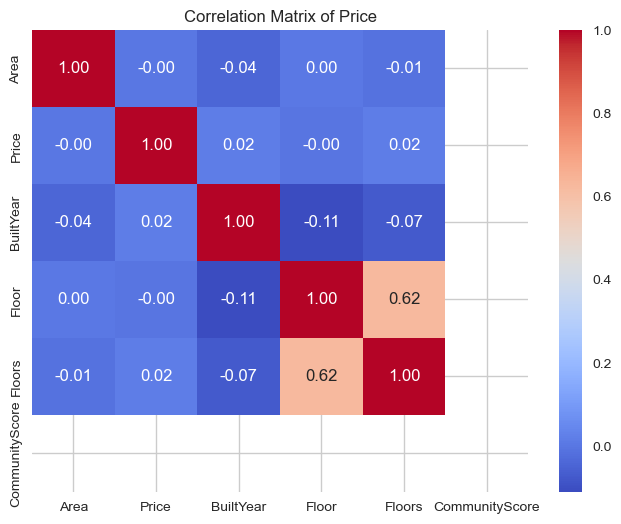

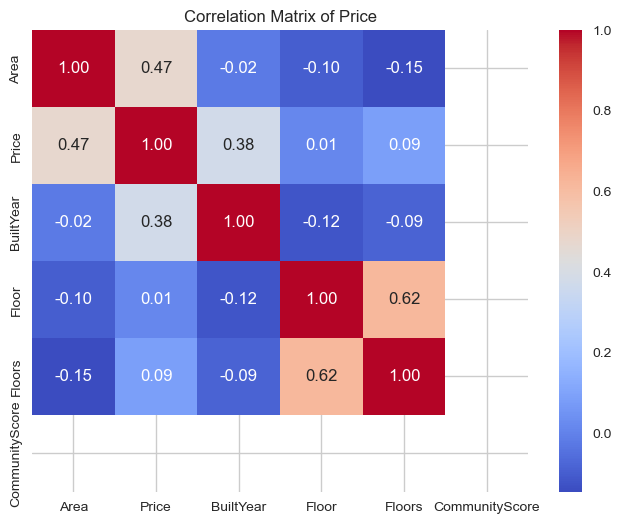

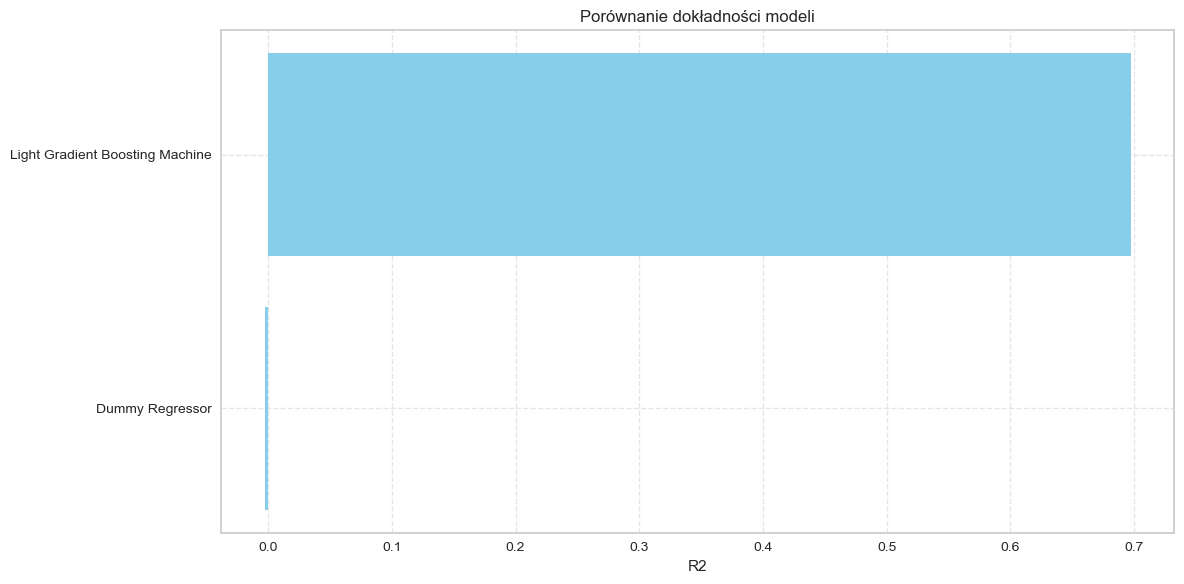

In [38]:
plt.figure(figsize=(12, 6))
plt.barh(unbalanced_metrics_df['Model'], unbalanced_metrics_df['R2'], color='skyblue')
plt.xlabel('R2')
plt.title('Porównanie dokładności modeli')
plt.gca().invert_yaxis()  # najlepszy model na górze
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

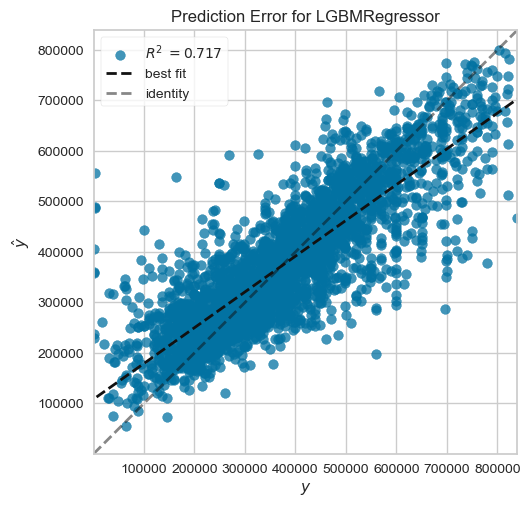

In [39]:
exp.plot_model(best_unbalanced_model, plot='error')

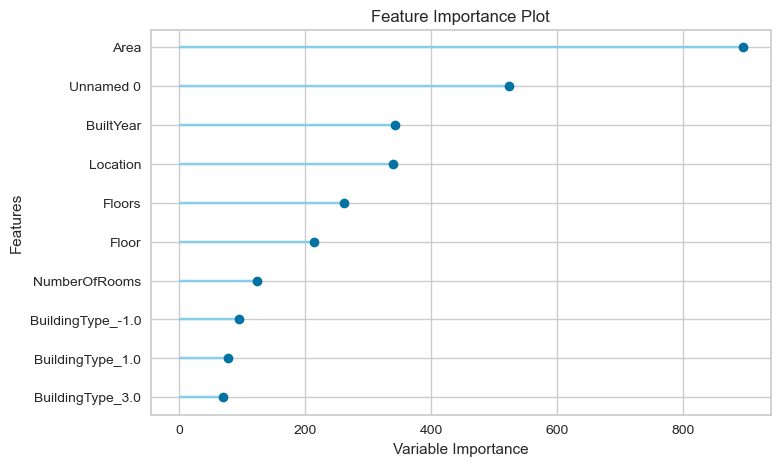

In [40]:
exp.plot_model(best_unbalanced_model, plot='feature')

In [41]:
tuned_model = exp.tune_model(best_unbalanced_model, n_iter=3, optimize='R2')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,63886.0374,7680712198.3388,87639.6725,0.6968,0.3361,0.3435
1,62599.3254,7754026921.2589,88056.9527,0.6550,0.4979,3.7015
2,64206.1088,8091367627.0766,89952.0296,0.6847,0.2884,0.2253
3,64442.5376,7631708529.8434,87359.6505,0.6573,0.4066,1.5637
4,69679.0831,10056446782.4278,100281.8368,0.6170,0.5354,2.0977
5,61537.1139,7083146343.8258,84161.4303,0.6784,0.3569,0.5380
6,59925.1748,7079947422.8342,84142.4234,0.6799,0.3184,0.4673
7,64303.7324,7750706255.2264,88038.0955,0.6862,0.4244,0.9026
8,64402.9419,8176604540.1156,90424.5793,0.6619,0.4569,1.7479


Fitting 10 folds for each of 3 candidates, totalling 30 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [42]:
best_model = exp.compare_models([best_unbalanced_model, tuned_model])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Light Gradient Boosting Machine,60201.8987,7319871182.2838,85448.8440,0.6973,0.4041,1.3713,0.1980
1,Light Gradient Boosting Machine,60201.8987,7319871182.2838,85448.8440,0.6973,0.4041,1.3713,0.2220


In [43]:
exp.predict_model(best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,58018.9763,6788091863.4751,82389.8772,0.7172,0.3899,1.0188


,Unnamed: 0,SaleId,Description,Area,NumberOfRooms,BuiltYear,BuildingType,BuildingCondition,Floor,Floors,Location,Predicted_State,Price,prediction_label
3574,3574,2313830,Dwupokojowe mieszkanie z balkonem w śródmieści...,45.299999,2.0,1977.0,Blok,NaN,4.0,NaN,"Opolskie, Opole, Ul. Marii Rodziewiczówny",DEVELOPER_STATE,409000.0,258270.700985
1322,1322,1573415,Sprzedam Mieszkanie 41 m Górażdze Fabryczna 42...,41.000000,1.0,NaN,Blok,NaN,0.0,NaN,"Opolskie, Strzelecki, Izbicko",DEVELOPER_STATE,135000.0,180604.751409
11181,11181,4072509,"Witam, na sprzedaż mieszkanie 2 pokojowe na 3 ...",37.000000,2.0,NaN,Blok,NaN,3.0,NaN,"Opolskie, Kędzierzyńsko-kozielski, Kędzierzyn-...",AFTER_RENOVATION,225000.0,226639.521468
1797,1797,1851114,Sprzedam Mieszkanie Bezczynszowe Do Remontu Kę...,65.500000,3.0,NaN,Kamienica,NaN,1.0,NaN,"Opolskie, Kędzierzyńsko-kozielski, Kędzierzyn-...",AFTER_RENOVATION,195000.0,369299.719008
1732,1732,1842936,"Apartament 3 pokojowy, duży balkon - wysoki pa...",59.000000,3.0,2021.0,Apartamentowiec,NaN,0.0,NaN,"Opolskie, Namysłowski, Namysłów",DEVELOPER_STATE,400000.0,477914.610473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4864,4864,2710571,"Mieszkanie, Nysa, Nysa (gm.), 49 m² Ogłoszenio...",49.000000,2.0,1970.0,Blok,NaN,4.0,4.0,"Opolskie, Nyski, Nysa",AFTER_RENOVATION,299000.0,296345.142409
3945,3945,2406932,"Mieszkanie 46m2 , 4 piętro , mieszkanie posiad...",46.000000,2.0,NaN,Blok,NaN,4.0,NaN,"Opolskie, Brzeski, Brzeg",AFTER_RENOVATION,245000.0,309977.753478
1400,1400,1664181,"Witam, na sprzedaż posiadam mieszkanie 3-pokoj...",82.400002,3.0,NaN,Kamienica,NaN,0.0,NaN,"Opolskie, Nyski, Nysa",AFTER_RENOVATION,389000.0,483053.935331
5345,5345,2791515,"Mieszkanie, Opole, Malinka, 54 m² Ogłoszenioda...",53.599998,2.0,NaN,Blok,NaN,2.0,3.0,"Opolskie, Opole",AFTER_RENOVATION,465000.0,474937.233876


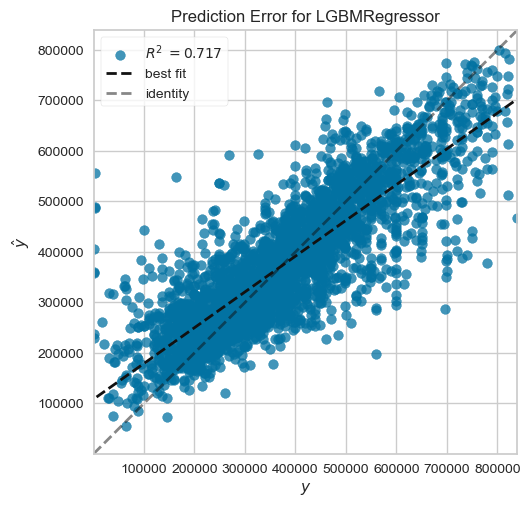

In [44]:
exp.plot_model(best_model, plot='error')

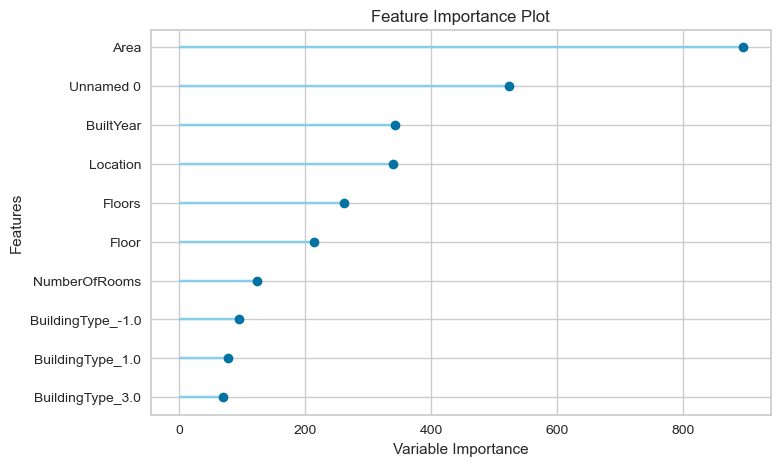

In [45]:
exp.plot_model(best_model, plot='feature')

In [46]:
best_tuned_model = exp.tune_model(
    best_model,
    optimize="R2",
    choose_better=True,
    fold=5,
)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,63155.8549,7709003813.6999,87800.9329,0.6786,0.4254,1.9855
1,62866.5547,7647447779.6859,87449.6871,0.6810,0.3488,0.8232
2,64608.2971,8383897115.8336,91563.6233,0.6530,0.4576,1.3354
3,61265.8023,7057748672.5005,84010.4081,0.6985,0.3696,0.6587
4,63288.0603,7884540915.8139,88794.9374,0.6908,0.4629,2.0103
Mean,63036.9139,7736527659.5068,87923.9178,0.6804,0.4128,1.3626
Std,1068.8615,426715089.3291,2431.5308,0.0154,0.0461,0.5647


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [47]:
exp.predict_model(best_tuned_model).head(10)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,58018.9763,6788091863.4751,82389.8772,0.7172,0.3899,1.0188


,Unnamed: 0,SaleId,Description,Area,NumberOfRooms,BuiltYear,BuildingType,BuildingCondition,Floor,Floors,Location,Predicted_State,Price,prediction_label
3574,3574,2313830,Dwupokojowe mieszkanie z balkonem w śródmieści...,45.299999,2.0,1977.0,Blok,NaN,4.0,NaN,"Opolskie, Opole, Ul. Marii Rodziewiczówny",DEVELOPER_STATE,409000.0,258270.700985
1322,1322,1573415,Sprzedam Mieszkanie 41 m Górażdze Fabryczna 42...,41.000000,1.0,NaN,Blok,NaN,0.0,NaN,"Opolskie, Strzelecki, Izbicko",DEVELOPER_STATE,135000.0,180604.751409
11181,11181,4072509,"Witam, na sprzedaż mieszkanie 2 pokojowe na 3 ...",37.000000,2.0,NaN,Blok,NaN,3.0,NaN,"Opolskie, Kędzierzyńsko-kozielski, Kędzierzyn-...",AFTER_RENOVATION,225000.0,226639.521468
1797,1797,1851114,Sprzedam Mieszkanie Bezczynszowe Do Remontu Kę...,65.500000,3.0,NaN,Kamienica,NaN,1.0,NaN,"Opolskie, Kędzierzyńsko-kozielski, Kędzierzyn-...",AFTER_RENOVATION,195000.0,369299.719008
1732,1732,1842936,"Apartament 3 pokojowy, duży balkon - wysoki pa...",59.000000,3.0,2021.0,Apartamentowiec,NaN,0.0,NaN,"Opolskie, Namysłowski, Namysłów",DEVELOPER_STATE,400000.0,477914.610473
3401,3401,2271806,"Mieszkanie o powierzchni 46,45 m2 na ósmym pię...",46.450001,3.0,NaN,Blok,NaN,8.0,NaN,"Opolskie, Opole",AFTER_RENOVATION,440000.0,440726.007463
1503,1503,1750477,Sprzedam mieszkanie znajdujące się w centrum B...,67.650002,3.0,NaN,Blok,NaN,0.0,NaN,"Opolskie, Głubczycki, Baborów",DEVELOPER_STATE,310000.0,267470.184675
12967,12967,4414583,Przestronne mieszkanie z balkonem w centrum Op...,80.639999,3.0,1970.0,Kamienica,GOOD,1.0,3.0,"Opolskie, Opole, Śródmieście",AFTER_RENOVATION,700000.0,602653.606586
7742,7742,3264564,Oferta A-12 Przedmiotem ogłoszenia jest 3-poko...,56.000000,3.0,2025.0,Blok,NaN,2.0,4.0,"Opolskie, Brzeski, Brzeg, Ul. Piwowarska",DEVELOPER_STATE,420000.0,424969.411388
4675,4675,2662612,Sprzedam mieszkanie w nowo ocieplonym budynku ...,48.000000,2.0,1987.0,Blok,NaN,4.0,4.0,"Opolskie, Prudnicki, Prudnik, Ul. Bończyka",AFTER_RENOVATION,174000.0,299344.971863


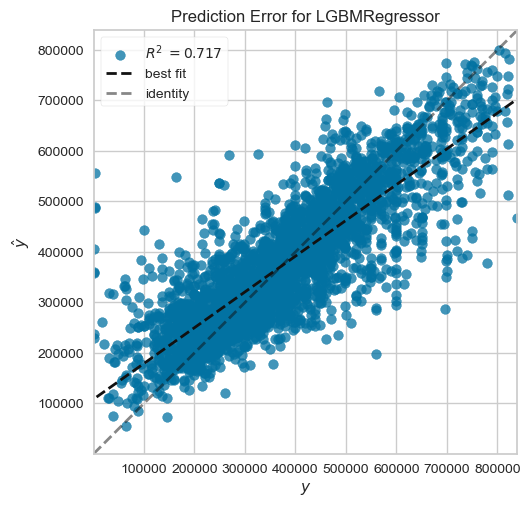

In [48]:
exp.plot_model(best_tuned_model, plot='error')

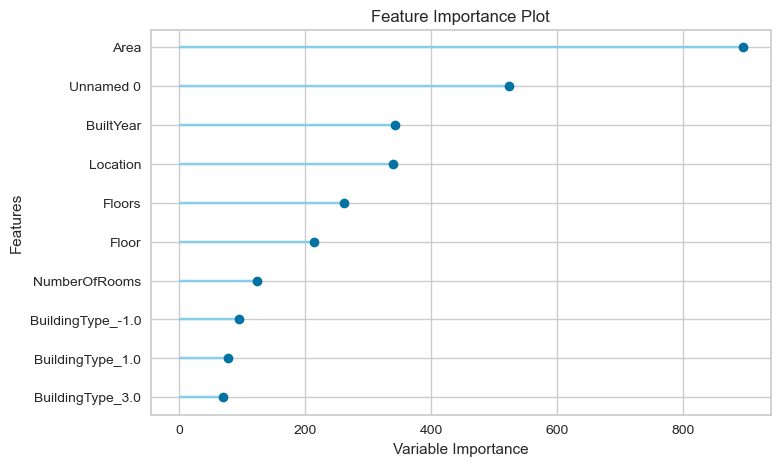

In [49]:
exp.plot_model(best_tuned_model, plot='feature')

In [50]:
best_final_model = exp.finalize_model(best_tuned_model)
best_final_model

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['Unnamed: 0', 'SaleId', 'Area',
                                             'NumberOfRooms', 'BuiltYear',
                                             'Floor', 'Floors'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['BuildingType', 'Predicted_State'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('ordinal_enc...
dtype: int64}]))),
                ('onehot_encoding',
                 TransformerWrapper(include=['BuildingType', 'Predicted_State'],
                                    transformer=OneHotEncoder(cols=['BuildingType',
                                                                    'Predicted_State'],
                                                              handle_missing='return_nan',
                                                              use_cat_names=True))),
                ('clean_column_names',
                 TransformerWrapper(transformer=CleanColumnNames())),
                ('actual_estimator',
                 LGBMRegressor(n_jobs=-1, random_state=1122))])

In [51]:
exp.save_model(best_final_model, "16_best_price_modelLGBM", verbose=False);

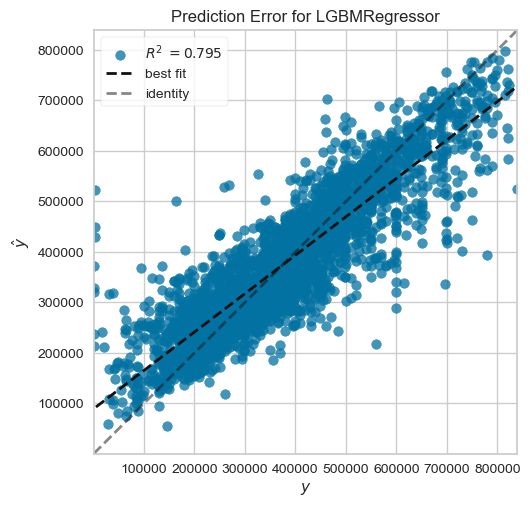

In [52]:
exp.plot_model(best_final_model, plot='error')

In [53]:
exp.predict_model(best_final_model).head(10)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,49114.2451,4922653256.1921,70161.6224,0.7949,0.3634,0.9166


,Unnamed: 0,SaleId,Description,Area,NumberOfRooms,BuiltYear,BuildingType,BuildingCondition,Floor,Floors,Location,Predicted_State,Price,prediction_label
3574,3574,2313830,Dwupokojowe mieszkanie z balkonem w śródmieści...,45.299999,2.0,1977.0,Blok,NaN,4.0,NaN,"Opolskie, Opole, Ul. Marii Rodziewiczówny",DEVELOPER_STATE,409000.0,275484.850403
1322,1322,1573415,Sprzedam Mieszkanie 41 m Górażdze Fabryczna 42...,41.000000,1.0,NaN,Blok,NaN,0.0,NaN,"Opolskie, Strzelecki, Izbicko",DEVELOPER_STATE,135000.0,177505.765896
11181,11181,4072509,"Witam, na sprzedaż mieszkanie 2 pokojowe na 3 ...",37.000000,2.0,NaN,Blok,NaN,3.0,NaN,"Opolskie, Kędzierzyńsko-kozielski, Kędzierzyn-...",AFTER_RENOVATION,225000.0,230072.607730
1797,1797,1851114,Sprzedam Mieszkanie Bezczynszowe Do Remontu Kę...,65.500000,3.0,NaN,Kamienica,NaN,1.0,NaN,"Opolskie, Kędzierzyńsko-kozielski, Kędzierzyn-...",AFTER_RENOVATION,195000.0,363991.818856
1732,1732,1842936,"Apartament 3 pokojowy, duży balkon - wysoki pa...",59.000000,3.0,2021.0,Apartamentowiec,NaN,0.0,NaN,"Opolskie, Namysłowski, Namysłów",DEVELOPER_STATE,400000.0,450370.667288
3401,3401,2271806,"Mieszkanie o powierzchni 46,45 m2 na ósmym pię...",46.450001,3.0,NaN,Blok,NaN,8.0,NaN,"Opolskie, Opole",AFTER_RENOVATION,440000.0,434498.303299
1503,1503,1750477,Sprzedam mieszkanie znajdujące się w centrum B...,67.650002,3.0,NaN,Blok,NaN,0.0,NaN,"Opolskie, Głubczycki, Baborów",DEVELOPER_STATE,310000.0,262331.761248
12967,12967,4414583,Przestronne mieszkanie z balkonem w centrum Op...,80.639999,3.0,1970.0,Kamienica,GOOD,1.0,3.0,"Opolskie, Opole, Śródmieście",AFTER_RENOVATION,700000.0,681042.002517
7742,7742,3264564,Oferta A-12 Przedmiotem ogłoszenia jest 3-poko...,56.000000,3.0,2025.0,Blok,NaN,2.0,4.0,"Opolskie, Brzeski, Brzeg, Ul. Piwowarska",DEVELOPER_STATE,420000.0,426824.149111
4675,4675,2662612,Sprzedam mieszkanie w nowo ocieplonym budynku ...,48.000000,2.0,1987.0,Blok,NaN,4.0,4.0,"Opolskie, Prudnicki, Prudnik, Ul. Bończyka",AFTER_RENOVATION,174000.0,283861.357118


In [54]:
predictions = exp.predict_model(best_final_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,49114.2451,4922653256.1921,70161.6224,0.7949,0.3634,0.9166


In [55]:
predicted_column = predictions['prediction_label']
print(predicted_column)

3574     275484.850403
1322     177505.765896
11181    230072.607730
1797     363991.818856
1732     450370.667288
             ...      
4864     288757.216537
3945     302545.903601
1400     464118.625842
5345     473141.362866
2258     161105.480085
Name: prediction_label, Length: 3481, dtype: float64


In [56]:
print(predictions[['prediction_label']].applymap('{:,.0f}'.format))

      prediction_label
3574           275,485
1322           177,506
11181          230,073
1797           363,992
1732           450,371
...                ...
4864           288,757
3945           302,546
1400           464,119
5345           473,141
2258           161,105

[3481 rows x 1 columns]


In [57]:
df_last=predictions[['prediction_label','Price', ]].applymap('{:,.0f}'.format)


In [58]:
df_last.to_csv('16_new_prices.csv')

In [59]:
print(df_last.columns)

Index(['prediction_label', 'Price'], dtype='object')


In [60]:
print(df_last.head())

      prediction_label    Price
3574           275,485  409,000
1322           177,506  135,000
11181          230,073  225,000
1797           363,992  195,000
1732           450,371  400,000


In [61]:
df_last = df_last.reset_index()  
print(df_last.columns)  

Index(['index', 'prediction_label', 'Price'], dtype='object')


In [62]:
df_last.rename(columns={'index': 'SaleId'}, inplace=True)

In [63]:
saleflats_df = pd.read_csv('16_sale_2024_stan.csv')

In [64]:
new_prices_df = pd.read_csv('16_new_prices.csv')

In [65]:
print("saleflats_df.columns:", saleflats_df.columns.tolist())

saleflats_df.columns: ['Unnamed: 0', 'SaleId', 'OriginalId', 'PortalId', 'Title', 'Description', 'Area', 'Price', 'OfferPrice', 'RealPriceAfterRenovation', 'OriginalPrice', 'PricePerSquareMeter', 'NumberOfRooms', 'BuiltYear', 'Type', 'BuildingType', 'BuildingCondition', 'OfferFrom', 'Floor', 'Floors', 'TypeOfMarket', 'OwnerType', 'DateAddedToDatabase', 'DateAdded', 'DateLastModification', 'DateLastRaises', 'NewestDate', 'AvailableFrom', 'Link', 'Phone', 'MainImage', 'OtherImages', 'NumberOfDuplicates', 'NumberOfRaises', 'NumberOfModifications', 'IsDuplicatePriceLower', 'IsDuplicatePrivateOwner', 'Score', 'ScorePrecision', 'CommunityScore', 'NumberOfCommunityComments', 'NumberOfCommunityOpinions', 'Archive', 'Location', 'VoivodeshipNumber', 'CountyNumber', 'CommunityNumber', 'KindNumber', 'RegionNumber', 'SubRegionNumber', 'StreetNumber', 'EncryptedId', 'Predicted_State']


In [66]:
print("new_prices_df.columns:", new_prices_df.columns.tolist())

new_prices_df.columns: ['Unnamed: 0', 'prediction_label', 'Price']


In [67]:
new_prices_df = new_prices_df.rename(columns={'Unnamed: 0': 'SaleID', 'Price': 'NewPrice'})

In [68]:
print("new_prices_df.columns:", new_prices_df.columns.tolist())

new_prices_df.columns: ['SaleID', 'prediction_label', 'NewPrice']


In [69]:
print(new_prices_df.columns)

Index(['SaleID', 'prediction_label', 'NewPrice'], dtype='object')


In [70]:
print(saleflats_df.columns)

Index(['Unnamed: 0', 'SaleId', 'OriginalId', 'PortalId', 'Title',
       'Description', 'Area', 'Price', 'OfferPrice',
       'RealPriceAfterRenovation', 'OriginalPrice', 'PricePerSquareMeter',
       'NumberOfRooms', 'BuiltYear', 'Type', 'BuildingType',
       'BuildingCondition', 'OfferFrom', 'Floor', 'Floors', 'TypeOfMarket',
       'OwnerType', 'DateAddedToDatabase', 'DateAdded', 'DateLastModification',
       'DateLastRaises', 'NewestDate', 'AvailableFrom', 'Link', 'Phone',
       'MainImage', 'OtherImages', 'NumberOfDuplicates', 'NumberOfRaises',
       'NumberOfModifications', 'IsDuplicatePriceLower',
       'IsDuplicatePrivateOwner', 'Score', 'ScorePrecision', 'CommunityScore',
       'NumberOfCommunityComments', 'NumberOfCommunityOpinions', 'Archive',
       'Location', 'VoivodeshipNumber', 'CountyNumber', 'CommunityNumber',
       'KindNumber', 'RegionNumber', 'SubRegionNumber', 'StreetNumber',
       'EncryptedId', 'Predicted_State'],
      dtype='object')


In [71]:
merged_df = pd.merge(
    saleflats_df,
    new_prices_df[['SaleID', 'NewPrice']],
    left_on='SaleId',  # Kolumna w saleflats_df
    right_on='SaleID',  # Kolumna w new_prices_df
    how='left'
)

In [72]:
merged_df

,Unnamed: 0,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,...,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId,Predicted_State,SaleID,NewPrice
0,0,83983,NaN,11,"Mieszkanie, Opole, Pasieka, 80 m²","Mieszkanie, Opole, Pasieka, 80 m² Ogłoszenioda...",80.00,760000.0,NaN,NaN,...,61,5.0,4.0,952232.0,NaN,9374.0,VFO80lZz2LDUKsePgyP7qr1cwColzIKnjrh_K5zWcDs=,AFTER_RENOVATION,NaN,NaN
1,1,85099,NaN,19,NOWA CENA!!!Sprzedam mieszkanie 47.5m2 2 pokoje,Sprzedam mieszkanie 47.5 M2 w Kędzierzyn-Koźle...,48.00,260000.0,NaN,NaN,...,3,1.0,1.0,965424.0,NaN,NaN,QYoMxlbcVyS4lZYH557rur1cwColzIKnjrh_K5zWcDs=,AFTER_RENOVATION,NaN,NaN
2,2,85987,NaN,19,"Apartament Nova Ozimska 57m, 3 pokoje, klima",Sprzedam apartament zlokalizowany na osiedlu N...,56.00,720000.0,NaN,NaN,...,61,1.0,1.0,965016.0,NaN,NaN,P5ugr2wcPhvZNpwHYJ5Pv71cwColzIKnjrh_K5zWcDs=,AFTER_RENOVATION,NaN,NaN
3,3,87630,NaN,14,Mieszkanie dwupokojowe na sprzedaż,Na sprzedaż bezczynszowe mieszkanie o pow. 64 ...,64.00,180000.0,NaN,NaN,...,6,2.0,4.0,965743.0,NaN,NaN,LcAizCdUeIZxyuZbnUAkar1cwColzIKnjrh_K5zWcDs=,DEVELOPER_STATE,NaN,NaN
4,4,88880,NaN,3,"Armii Krajowej 8A - mieszkanie 2 pokoje - 46, ...",Sprzedam mieszkanie w budynku mieszkalnym wiel...,46.65,320000.0,NaN,NaN,...,1,1.0,1.0,965252.0,NaN,NaN,Z8_2vWdAHXs5NpdBDIQ9WL1cwColzIKnjrh_K5zWcDs=,AFTER_RENOVATION,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12987,12987,4417782,NaN,3,Przytulne mieszkanie z dużym tarasem,Przedstawiam ofertę sprzedaży wyjątkowo ciepłe...,43.90,520000.0,NaN,NaN,...,61,1.0,1.0,965051.0,NaN,10099.0,aZpC4_JMV3__QDZaDhLbXqi_rC3KFy_RnfS0EWfIRU4=,DEVELOPER_STATE,NaN,NaN
12988,12988,4418029,NaN,32,"Sprzedam mieszkanie 67,17 m Namysłów","Sprzedam mieszkanie o powierzchni 67,17 m w no...",67.00,455000.0,429500.0,491000.00,...,6,2.0,4.0,NaN,NaN,NaN,FiLEXYFRQ_ebc4br8lpc6-bQxVp1jDeL4EC2z-A_Xv4=,DEVELOPER_STATE,NaN,NaN
12989,12989,4418038,NaN,4,3-pokojowe mieszkanie na sprzedaż,82 m² | 3 pokoje | Taras 20 m² | Garaż + 2 mie...,82.00,820000.0,839000.0,899000.00,...,61,1.0,1.0,496774.0,NaN,NaN,FiLEXYFRQ_ebc4br8lpc6z4_dpxrDGt-7ptnSFX67Aw=,DEVELOPER_STATE,NaN,NaN
12990,12990,4418076,NaN,3,Mieszkanie z gwarancją dochodu| 2 pokoje| nowe...,"Na sprzedaż 2-pokojowe, w pełni wyposażone mie...",34.00,510000.0,377500.0,505000.00,...,61,NaN,NaN,NaN,NaN,NaN,FiLEXYFRQ_ebc4br8lpc62jzzGldvCsejqBZGAbYChc=,AFTER_RENOVATION,NaN,NaN


In [73]:
# Krok 2: usuwanie dodatkowej kolumny klucza (opcjonalnie, bo mamy już 'SaleId')
merged_df.drop(columns=['SaleID'], inplace=True)

# Krok 3: przestawienie kolumny 'NewPrice' obok 'Price'
cols = merged_df.columns.tolist()

# znajdź indeks kolumny 'Price'
price_index = cols.index('Price')

# usuń NewPrice z listy i dodaj ją zaraz po Price
cols.remove('NewPrice')
cols.insert(price_index + 1, 'NewPrice')

# ustaw nową kolejność kolumn
merged_df = merged_df[cols]

In [74]:
prediction_df = merged_df.copy()

In [75]:
from pycaret.regression import predict_model

In [76]:
prediction_df_clean = prediction_df.drop(columns=['Price'], errors='ignore')
predictions = predict_model(best_final_model, data=prediction_df_clean)

In [77]:
predictions['RealPrice'] = prediction_df['Price']

In [78]:
merged_df['PredictedPrice'] = predictions['prediction_label']

In [79]:
predictions=predictions[['prediction_label',]].applymap('{:,.0f}'.format)

In [80]:
# Przenieś kolumnę 'PredictedPrice' za 'NewPrice'
cols = list(merged_df.columns)
new_price_index = cols.index('NewPrice')
# Usuń z listy kolumn
cols.remove('PredictedPrice')
# Dodaj w odpowiednie miejsce
cols.insert(new_price_index + 1, 'PredictedPrice')
# Przekształć DataFrame
merged_df = merged_df[cols]

In [81]:
merged_df.to_csv('16_new_prices_full.csv')

In [82]:
merged_df = pd.read_csv('16_new_prices_full.csv')

In [83]:
merged_df

,Unnamed: 0.1,Unnamed: 0,SaleId,OriginalId,PortalId,Title,Description,Area,Price,NewPrice,...,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId,Predicted_State
0,0,0,83983,NaN,11,"Mieszkanie, Opole, Pasieka, 80 m²","Mieszkanie, Opole, Pasieka, 80 m² Ogłoszenioda...",80.00,760000.0,NaN,...,"Opolskie, Opole",16,61,5.0,4.0,952232.0,NaN,9374.0,VFO80lZz2LDUKsePgyP7qr1cwColzIKnjrh_K5zWcDs=,AFTER_RENOVATION
1,1,1,85099,NaN,19,NOWA CENA!!!Sprzedam mieszkanie 47.5m2 2 pokoje,Sprzedam mieszkanie 47.5 M2 w Kędzierzyn-Koźle...,48.00,260000.0,NaN,...,"Opolskie, Kędzierzyńsko-kozielski, Kędzierzyn-...",16,3,1.0,1.0,965424.0,NaN,NaN,QYoMxlbcVyS4lZYH557rur1cwColzIKnjrh_K5zWcDs=,AFTER_RENOVATION
2,2,2,85987,NaN,19,"Apartament Nova Ozimska 57m, 3 pokoje, klima",Sprzedam apartament zlokalizowany na osiedlu N...,56.00,720000.0,NaN,...,"Opolskie, Opole",16,61,1.0,1.0,965016.0,NaN,NaN,P5ugr2wcPhvZNpwHYJ5Pv71cwColzIKnjrh_K5zWcDs=,AFTER_RENOVATION
3,3,3,87630,NaN,14,Mieszkanie dwupokojowe na sprzedaż,Na sprzedaż bezczynszowe mieszkanie o pow. 64 ...,64.00,180000.0,NaN,...,"Opolskie, Namysłowski, Namysłów",16,6,2.0,4.0,965743.0,NaN,NaN,LcAizCdUeIZxyuZbnUAkar1cwColzIKnjrh_K5zWcDs=,DEVELOPER_STATE
4,4,4,88880,NaN,3,"Armii Krajowej 8A - mieszkanie 2 pokoje - 46, ...",Sprzedam mieszkanie w budynku mieszkalnym wiel...,46.65,320000.0,NaN,...,"Opolskie, Brzeski, Brzeg",16,1,1.0,1.0,965252.0,NaN,NaN,Z8_2vWdAHXs5NpdBDIQ9WL1cwColzIKnjrh_K5zWcDs=,AFTER_RENOVATION
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12987,12987,12987,4417782,NaN,3,Przytulne mieszkanie z dużym tarasem,Przedstawiam ofertę sprzedaży wyjątkowo ciepłe...,43.90,520000.0,NaN,...,"Opolskie, Opole, Gosławice, Ul. Krzemieniecka",16,61,1.0,1.0,965051.0,NaN,10099.0,aZpC4_JMV3__QDZaDhLbXqi_rC3KFy_RnfS0EWfIRU4=,DEVELOPER_STATE
12988,12988,12988,4418029,NaN,32,"Sprzedam mieszkanie 67,17 m Namysłów","Sprzedam mieszkanie o powierzchni 67,17 m w no...",67.00,455000.0,NaN,...,"Opolskie, Namysłowski, Namysłów",16,6,2.0,4.0,NaN,NaN,NaN,FiLEXYFRQ_ebc4br8lpc6-bQxVp1jDeL4EC2z-A_Xv4=,DEVELOPER_STATE
12989,12989,12989,4418038,NaN,4,3-pokojowe mieszkanie na sprzedaż,82 m² | 3 pokoje | Taras 20 m² | Garaż + 2 mie...,82.00,820000.0,NaN,...,"Opolskie, Opole, Chmielowice",16,61,1.0,1.0,496774.0,NaN,NaN,FiLEXYFRQ_ebc4br8lpc6z4_dpxrDGt-7ptnSFX67Aw=,DEVELOPER_STATE
12990,12990,12990,4418076,NaN,3,Mieszkanie z gwarancją dochodu| 2 pokoje| nowe...,"Na sprzedaż 2-pokojowe, w pełni wyposażone mie...",34.00,510000.0,NaN,...,"Opolskie, Opole",16,61,NaN,NaN,NaN,NaN,NaN,FiLEXYFRQ_ebc4br8lpc62jzzGldvCsejqBZGAbYChc=,AFTER_RENOVATION


In [84]:
merged_df2=merged_df[['PredictedPrice',]].applymap('{:,.0f}'.format)

In [85]:
merged_df2

,PredictedPrice
0,"610,428"
1,"260,314"
2,"642,652"
3,"237,176"
4,"372,147"
...,...
12987,"409,776"
12988,"573,671"
12989,"717,775"
12990,"405,486"


In [86]:
merged_df['PredictedPrice'] = merged_df2['PredictedPrice']

In [87]:
merged_df

,Unnamed: 0.1,Unnamed: 0,SaleId,OriginalId,PortalId,Title,Description,Area,Price,NewPrice,...,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId,Predicted_State
0,0,0,83983,NaN,11,"Mieszkanie, Opole, Pasieka, 80 m²","Mieszkanie, Opole, Pasieka, 80 m² Ogłoszenioda...",80.00,760000.0,NaN,...,"Opolskie, Opole",16,61,5.0,4.0,952232.0,NaN,9374.0,VFO80lZz2LDUKsePgyP7qr1cwColzIKnjrh_K5zWcDs=,AFTER_RENOVATION
1,1,1,85099,NaN,19,NOWA CENA!!!Sprzedam mieszkanie 47.5m2 2 pokoje,Sprzedam mieszkanie 47.5 M2 w Kędzierzyn-Koźle...,48.00,260000.0,NaN,...,"Opolskie, Kędzierzyńsko-kozielski, Kędzierzyn-...",16,3,1.0,1.0,965424.0,NaN,NaN,QYoMxlbcVyS4lZYH557rur1cwColzIKnjrh_K5zWcDs=,AFTER_RENOVATION
2,2,2,85987,NaN,19,"Apartament Nova Ozimska 57m, 3 pokoje, klima",Sprzedam apartament zlokalizowany na osiedlu N...,56.00,720000.0,NaN,...,"Opolskie, Opole",16,61,1.0,1.0,965016.0,NaN,NaN,P5ugr2wcPhvZNpwHYJ5Pv71cwColzIKnjrh_K5zWcDs=,AFTER_RENOVATION
3,3,3,87630,NaN,14,Mieszkanie dwupokojowe na sprzedaż,Na sprzedaż bezczynszowe mieszkanie o pow. 64 ...,64.00,180000.0,NaN,...,"Opolskie, Namysłowski, Namysłów",16,6,2.0,4.0,965743.0,NaN,NaN,LcAizCdUeIZxyuZbnUAkar1cwColzIKnjrh_K5zWcDs=,DEVELOPER_STATE
4,4,4,88880,NaN,3,"Armii Krajowej 8A - mieszkanie 2 pokoje - 46, ...",Sprzedam mieszkanie w budynku mieszkalnym wiel...,46.65,320000.0,NaN,...,"Opolskie, Brzeski, Brzeg",16,1,1.0,1.0,965252.0,NaN,NaN,Z8_2vWdAHXs5NpdBDIQ9WL1cwColzIKnjrh_K5zWcDs=,AFTER_RENOVATION
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12987,12987,12987,4417782,NaN,3,Przytulne mieszkanie z dużym tarasem,Przedstawiam ofertę sprzedaży wyjątkowo ciepłe...,43.90,520000.0,NaN,...,"Opolskie, Opole, Gosławice, Ul. Krzemieniecka",16,61,1.0,1.0,965051.0,NaN,10099.0,aZpC4_JMV3__QDZaDhLbXqi_rC3KFy_RnfS0EWfIRU4=,DEVELOPER_STATE
12988,12988,12988,4418029,NaN,32,"Sprzedam mieszkanie 67,17 m Namysłów","Sprzedam mieszkanie o powierzchni 67,17 m w no...",67.00,455000.0,NaN,...,"Opolskie, Namysłowski, Namysłów",16,6,2.0,4.0,NaN,NaN,NaN,FiLEXYFRQ_ebc4br8lpc6-bQxVp1jDeL4EC2z-A_Xv4=,DEVELOPER_STATE
12989,12989,12989,4418038,NaN,4,3-pokojowe mieszkanie na sprzedaż,82 m² | 3 pokoje | Taras 20 m² | Garaż + 2 mie...,82.00,820000.0,NaN,...,"Opolskie, Opole, Chmielowice",16,61,1.0,1.0,496774.0,NaN,NaN,FiLEXYFRQ_ebc4br8lpc6z4_dpxrDGt-7ptnSFX67Aw=,DEVELOPER_STATE
12990,12990,12990,4418076,NaN,3,Mieszkanie z gwarancją dochodu| 2 pokoje| nowe...,"Na sprzedaż 2-pokojowe, w pełni wyposażone mie...",34.00,510000.0,NaN,...,"Opolskie, Opole",16,61,NaN,NaN,NaN,NaN,NaN,FiLEXYFRQ_ebc4br8lpc62jzzGldvCsejqBZGAbYChc=,AFTER_RENOVATION


In [88]:
merged_df.drop(columns=['NewPrice'], inplace=True)

In [89]:
merged_df.to_csv('16_new_prices_full.csv')

In [ ]:
# df_p = pd.read_csv('sale_2024_6.csv')

# 1. Kopia oryginalnej dużej tabeli
df = df_p.copy()

# 2. Dopinamy kolumnę z predykcjami po SaleId
if 'NewPrices' in merged_df.columns:
    df = df.merge(merged_df[['SaleId', 'NewPrices']], on='SaleId', how='left')
elif 'PredictedPrice' in merged_df.columns:
    df = df.merge(merged_df[['SaleId', 'PredictedPrice']].rename(columns={'PredictedPrice': 'NewPrices'}), on='SaleId', how='left')
else:
    raise ValueError("W merged_df nie znaleziono kolumny 'NewPrices' ani 'PredictedPrice'")

# 3. Tam, gdzie jest dostępna cena ('Price'), kopiujemy ją do 'NewPrices'
df.loc[df['Price'].notna(), 'NewPrices'] = df.loc[df['Price'].notna(), 'Price']

# 4. Przenosimy kolumnę 'NewPrices' za 'Price'
cols = df.columns.tolist()
if 'NewPrices' in cols:
    cols.remove('NewPrices')
    price_idx = cols.index('Price')
    cols.insert(price_idx + 1, 'NewPrices')
    df = df[cols]

# 5. Załaduj model z PyCaret
model = load_model('6_best_price_modelLGBM')

# 6. Przygotuj dane bez kolumny 'Price', by uniknąć błędu z NaN
df_for_prediction = df.drop(columns=['Price'], errors='ignore')

# 7. Przeprowadź predykcję
predicted_df = predict_model(model, data=df_for_prediction)

# 8. Powiąż wynik predykcji po SaleID
df = df.merge(predicted_df[['SaleID', 'prediction_label']], on='SaleID', how='left', suffixes=('', '_new'))

# 9. Nadpisz kolumnę 'NewPrices' nowymi przewidywaniami
df['NewPrices'] = df['prediction_label']

# 10. Przenosimy kolumnę 'NewPrices' za 'Price' (jeszcze raz)
cols = df.columns.tolist()
if 'NewPrices' in cols:
    cols.remove('NewPrices')
    price_idx = cols.index('Price')
    cols.insert(price_idx + 1, 'NewPrices')
    df = df[cols]

# 11. Zaktualizuj saleflats_b
saleflats_b = df

df2=df[['NewPrices',]].applymap('{:,.0f}'.format)

# Nadpisanie kolumny 'NewPrices' w df sformatowaną wersją
df['NewPrices'] = df2['NewPrices']

df

df.to_csv('6_new_prices_FULL2.csv')

df.sample(100)